In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as opt
import torch.nn as nn
import torch

import numpy as np
from src.voc_dataset import *
from src.region_proposal import RegionProposalNetwork, get_target_weights
from src.generate_anchor_data import AnchorDataGenerator
from src.generate_anchors import generate_anchors
from src.anchor_util import generate_all_anchors
from src.proposal import ProposalGenerator

import pickle

In [69]:
dataset = VOCDataSet("data/", "train", include_gt_lable=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=collate_fn)
iterator = iter(dataloader)

In [140]:
rpn = RegionProposalNetwork().cuda()
anchor_generator = AnchorDataGenerator().cuda()
log_softmax_func = nn.LogSoftmax().cuda()
nll_loss_func = nn.NLLLoss2d(weight=get_target_weights(), size_average=False).cuda()
regression_loss_func = nn.SmoothL1Loss(size_average=False).cuda()

optimizer = opt.SGD(
         rpn.parameters(),
         lr=0.001,
         momentum=0.9,
         weight_decay=0.0005,
     )

In [146]:
a = []
for i in range(200):    
    image_arr, gt, labels = iterator.next()
    image_arr = Variable(image_arr).cuda()
    gt = Variable(gt)
    logits, regressions = rpn(image_arr)

    width = Variable(torch.Tensor([logits.size(3)]))
    height = Variable(torch.Tensor([logits.size(2)]))
    im_w = Variable(torch.Tensor([image_arr.size(3)]))
    im_h = Variable(torch.Tensor([image_arr.size(2)]))

    labels, bbox_targets, bbox_inside_weights, regression_norm = \
                    anchor_generator(width, height, gt, im_w, im_h)

    logits = logits.view(1, 2, 9 * logits.size(2), logits.size(3))
    labels = labels.view(1, labels.size(2), labels.size(3)).cuda()
    bbox_inside_weights = bbox_inside_weights.cuda()
    bbox_targets = bbox_targets.cuda()
    regression_norm = regression_norm.cuda()

    log_softmax = log_softmax_func(logits)
    log_softmax = torch.cat(
        (
            log_softmax,
            Variable(torch.zeros([1, 1, log_softmax.size(2), log_softmax.size(3)])).cuda()
        ), 1)
    nll_loss = nll_loss_func(log_softmax, labels) / 256.

    regressions = torch.mul(regressions, bbox_inside_weights)
    bbox_targets = torch.mul(bbox_targets, bbox_inside_weights)
    regression_loss = regression_loss_func(regressions, bbox_targets) * (regression_norm + 1e-4)

    loss = nll_loss + regression_loss
    loss.backward()

    l = []
    for m in rpn.modules():
        if isinstance(m, nn.Conv2d):
            l.append(m.weight.grad.data.norm())
        elif isinstance(m, nn.Linear):
            l.append(m.weight.grad.data.norm())
    a.append(l[-1])

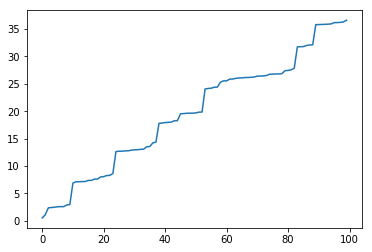

In [144]:
plt.plot(np.arange(0, 100), a)